In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import classification_report

## *Objetivo: El problema propuesto consiste en predecir la categoría a la que pertenece un anunció a partir de su título*

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('x_test.csv')

In [7]:
df_train.shape

(107191, 2)

In [8]:
df_test.head()

,Id,title,Predicted
0,0,Collar Marga Black,NaN
1,1,Microfono Condenser Rode Nt5,NaN
2,2,Apple Watch + Nike 42mm Silver Aluminum Case P...,NaN
3,3,Casco Abierto Shiro Sh-62 Monocolor Gris - Um,NaN
4,4,Jeans Negro Roto Chupin Hombre Ybr Jeans,NaN


In [9]:
gr = df_train.groupby(['category']).size().reset_index(name='counts')
gr

,category,counts
0,ACTION_FIGURES,2763
1,AUTOMOTIVE_CLUTCH_KITS,2036
2,AUTOMOTIVE_SIDE_VIEW_MIRRORS,2075
3,BABY_CAR_SEATS,1732
4,BABY_STROLLERS,2015
5,BACKPACKS,2478
6,BOARD_GAMES,2119
7,BOOKS,2738
8,CAR_STEREOS,2182
9,CATS_AND_DOGS_FOODS,2060


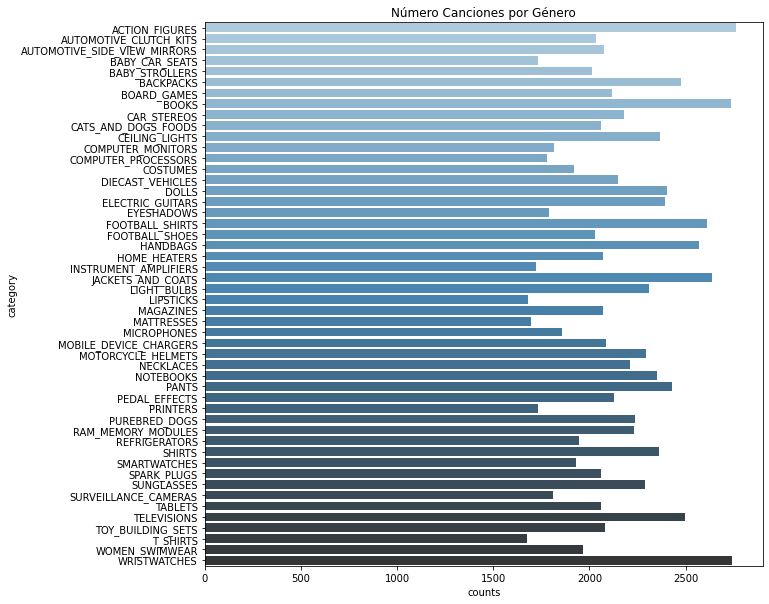

In [10]:
fig, ax = plt.subplots(figsize=(10,10),nrows=1)
sns.barplot(data=gr, y='category', x='counts', palette="Blues_d",ax=ax)
ax.set_title('Número Canciones por Género')
plt.show()

# Procesamiento de datos

## Encoding de las clases usando `LabelBinarizer`

In [11]:
from sklearn.preprocessing import LabelBinarizer

In [54]:
lb = LabelBinarizer()

In [55]:
Y = lb.fit_transform(df_train.category)

In [56]:
Y.shape

(107191, 50)

In [83]:
Y = df_train.category

## Pre-procesamiento de texto

In [16]:
import nltk

In [17]:
nltk.download('all-corpora')
nltk.download('all')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloadin

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TfidfVectorizer().build_tokenizer()

In [19]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [21]:
##stop-words: el vectorizador ya las remueve pero para mostrar las palabras más frecuente tiene sentido activarlo
remove_stops_here = True

def my_pre_processer(text):
    results = []
    for token in tokenizer(text):
        clean_token = token.lower().strip().strip('-').strip('_')
        if remove_stops_here and (clean_token in stopwords.words('spanish')):
          continue
        #token_pro = stemmer.stem(clean_token) #podemos probar stemming en vez de lematizacion
        token_pro = lemmatizer.lemmatize(clean_token) 
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

In [22]:
print(df_train.title.values[1])
print(my_pre_processer(df_train.title.values[1]))

Kit 4 Bujias Ngk Ford F-100 3.0 Bp5efs
['kit', 'bujias', 'ngk', 'ford', 'bp5efs']


In [81]:
ngram_max = 1
max_features = 10000
max_df=0.8
min_df=1

#vectorizer = TfidfVectorizer(stop_words=None,tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))

vectorizer = TfidfVectorizer(encoding='latin-1',max_df=0.90, min_df=5, max_features=9000)

In [82]:
%%time
vectorizer.fit(df_train.title)
vector_titles = vectorizer.transform(df_train.title)

CPU times: user 2.88 s, sys: 3.4 ms, total: 2.88 s
Wall time: 2.88 s


In [84]:
X = vector_titles

## El SMOTE

In [85]:
from imblearn.over_sampling import SMOTE

In [86]:
oversample = SMOTE(random_state=42)

In [87]:
X,Y = oversample.fit_resample(X, Y)

## Splits datasets

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
#X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [90]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(X_val.shape, y_val.shape)

(96705, 9000) (96705,)
(41445, 9000) (41445,)


## El multinomial que le dicen po

In [91]:
from sklearn.linear_model import LogisticRegression

In [92]:
clf = LogisticRegression(max_iter=1000)

In [93]:
%%time
clf.fit(X_train, y_train)

CPU times: user 3min 19s, sys: 3min 29s, total: 6min 48s
Wall time: 1min 9s


LogisticRegression(max_iter=1000)

In [94]:
s_train = clf.score(X_train, y_train)
s_test = clf.score(X_test, y_test)
print(s_train, s_test)

0.984602657566827 0.9781397032211364


In [95]:
X_train.shape

(96705, 9000)

In [96]:
y_test_pred = clf.predict(X_test)

In [97]:
y_test_pred.shape

(41445,)

In [98]:
y_test_pred

array(['HOME_HEATERS', 'MOBILE_DEVICE_CHARGERS', 'PEDAL_EFFECTS', ...,
       'NECKLACES', 'DOLLS', 'PEDAL_EFFECTS'], dtype=object)

In [99]:
from sklearn.metrics import balanced_accuracy_score

In [100]:
balanced_accuracy_score(y_test, y_test_pred)

0.9781692748302031

In [101]:
print(classification_report(y_test, y_test_pred))

                              precision    recall  f1-score   support

              ACTION_FIGURES       0.82      0.95      0.88       809
      AUTOMOTIVE_CLUTCH_KITS       1.00      1.00      1.00       808
AUTOMOTIVE_SIDE_VIEW_MIRRORS       1.00      1.00      1.00       799
              BABY_CAR_SEATS       0.98      0.99      0.99       833
              BABY_STROLLERS       0.99      0.98      0.99       809
                   BACKPACKS       0.98      0.99      0.99       821
                 BOARD_GAMES       0.94      0.95      0.95       819
                       BOOKS       0.88      0.90      0.89       836
                 CAR_STEREOS       0.99      0.98      0.99       806
         CATS_AND_DOGS_FOODS       0.99      0.99      0.99       869
              CEILING_LIGHTS       0.94      0.95      0.94       844
           COMPUTER_MONITORS       0.99      0.98      0.99       857
         COMPUTER_PROCESSORS       1.00      0.98      0.99       829
                   

## Prediccion pulenta

In [102]:
%%time
vectorizer.fit(df_test.title)
vector_titles_submission = vectorizer.transform(df_test.title)

CPU times: user 2.1 s, sys: 0 ns, total: 2.1 s
Wall time: 2.1 s


In [103]:
vector_titles_submission.shape

(71461, 9000)

In [104]:
vector_titles_submission[0]

<1x9000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [105]:
y_pred_submission = clf.predict(vector_titles_submission)

In [106]:
y_pred_submission.shape

(71461,)

In [107]:
#df_test.Predicted = lb.inverse_transform(y_pred_submission)
df_test.Predicted = y_pred_submission

In [111]:
df_test.head(50)

,Id,title,Predicted
0,0,Collar Marga Black,ACTION_FIGURES
1,1,Microfono Condenser Rode Nt5,INSTRUMENT_AMPLIFIERS
2,2,Apple Watch + Nike 42mm Silver Aluminum Case P...,BOOKS
3,3,Casco Abierto Shiro Sh-62 Monocolor Gris - Um,ACTION_FIGURES
4,4,Jeans Negro Roto Chupin Hombre Ybr Jeans,PANTS
5,5,Monitor Samsung 28 4k U28e590d Uhd 3840x2160 F...,BOOKS
6,6,Cargador + Usb + Auriculares Ultima Unidad En ...,BOARD_GAMES
7,7,Cargador De Pared 2a Con Doble Usb,DIECAST_VEHICLES
8,8,Impresora Laser Canon 6030w Wifi Reemp Hp 1102...,JACKETS_AND_COATS
9,9,Remeras Personalizadas Sublimadas O Esyampadas,WOMEN_SWIMWEAR


### save submission

In [ ]:
df_submission = pd.read_csv('sample_submission.csv')

In [ ]:
df_submission.head()

In [ ]:
df_submission.Predicted = df_test.Predicted

In [ ]:
df_submission.head()

In [ ]:
df_submission.to_csv('last_submission.csv', index=False, header=True)